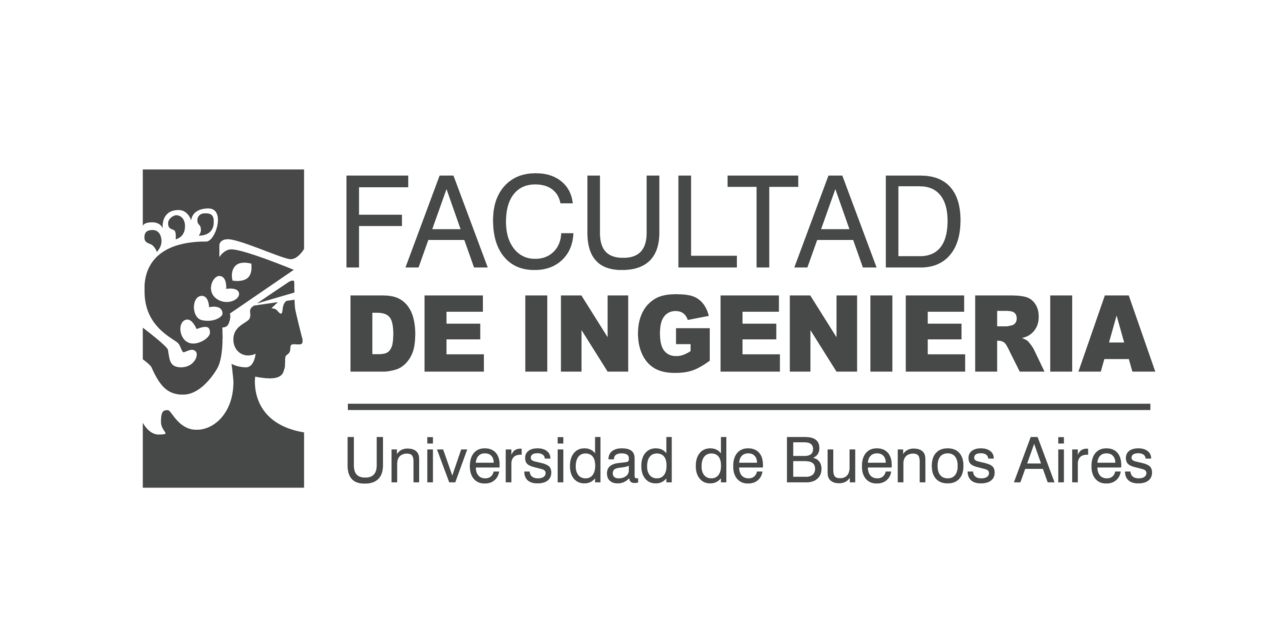

**Profesores:** <br />
Dr. Facundo Adrián Lucianna - facundolucianna@gmail.com <br />
Dr. Álvaro Gabriel Pizá - piza.ag@gmail.com <br />

**Alumnos:** <br />
Ing. Pablo Martin Gomez Verdini - gomezpablo86@gmail.com <br />
Ing. Diego Paciotti Iacchelli - diegopaciotti@gmail.com  <br />
Ing. Joaquin Gonzalez - joagonzalez@gmail.com <br />

**Repositorio Github**<br />
https://github.com/FIUBA-CEIA-18Co2024/AMIA-TP3 <br />


# TP integrador: Aprendizaje de Máquina 1

In [1]:
from IPython.display import display, Markdown

### Objetivos de la materia:
El objetivo está centrado en disponer de las herramientas de machine learning como así también la pericia para poder evaluar de antemano los diferentes casos de aplicación de técnicas de machine learning.

### Evaluación
La evaluación de los conocimientos impartidos durante las clases será a modo de entrega de trabajo práctico final. La entrega de trabajo final de la cursada comprende de una investigación, desarrollo y resultados finales basados en un set de datos a elección por el grupo (máximo 6 personas).

### Criterios de aprobación
Los criterios de aprobación son los siguientes:

- Obligación de trabajar en grupo mínimo de 2 y máximo de 6. Excepciones se pueden hacer mediante un correcto justificativo.
- Cada TP debe citar la fuente de información de evaluación, es decir, citar de donde se obtuvieron los datos.
- Puede ser entregado en cualquier formato, preferentemente en notebook de ipython (formato ipynb). También puede entregarse mediante un documento en Google Colab.
- Contendrá la propuesta de investigación en los datos, citando el porqué de la evaluación y que se pretende encontrar o descubrir con dicha investigación
- Deberá explicar el porqué de la elección del algoritmo empleado para la resolución del problema y cómo llegó a esa elección por sobre otras opciones
- Deberá expresar de manera clara el resultado de la investigación aportando las métricas necesarias para comprender cómo se desempeña el algoritmo elegido.
- El entregable debe venir con el código acompañado para su reproducibilidad. 
- En su cierre debe dar una reflexión de su investigación y proponer nuevos caminos de resolución en el caso de que sea necesario. 
- Como última fecha de entrega del trabajo, estará limitado a 7 días posteriores a la última clase.
- La entrega es por el aula virtual, ya sea el envío del contenido o el link a repositorio (de GitHub o GitLab) con el trabajo.

## Tabla de Contenido
1. [Pipeline de trabajo](#Pipeline-de-trabajo)
2. [Pre procesamiento de los datos](#Pre-procesamiento-de-los-datos)
3. [Busqueda de Hiper parámetros](#Busqueda-de-Hiper-Parámetros)
4. [Inferencia de los modelos y comparaciones](#Inferencia-de-los-modelos-y-comparaciones)
5. [Conclusiones](#conclusiones)

# Pipeline de trabajo

Con el fin de trabajar con los temas vistos durante la cursada, elegimos cómo como dataset [Trip Advisor Hotel Reviews](https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews) con la idea de hacer una predicción de puntuación de las reviews y luego compararla con un análisis mas acotado de sentimientos Negativos, Neutros y Positivos.
Se realizó un fuerte trabajo en la preparación y normalización del dataset para ser utilizado en varios de los modelos vistos en clase.
Se eligió como línea base la regresión logística vista en Intro a IA y se utilizaron para comparar clasificadores basados en SVM (kernel lineal y rbf), LightGBM y Catboost. Adicionalmente algunos de estos modelos se usaron para hacer ensemble con la idea de compensar losp untos debiles entre ellos.
Se realizaron busquedas de hiperparámetros con Optuna para obtener los mejores modelos y luego se los comparó en performance para poder obttener conclusiones 

El proceso seguido para realizar el análisis de sentimientos del dataset de reviews de TripAdvisor consta de los siguientes pasos:

1. **Preparación de datos**:
   - Limpieza y preprocesamiento de las reviews.
2. **Extracción de características**:
   - Creación de una matriz dispersa utilizando TF-IDF.
3. **Reducción de dimensionalidad**:
   - Aplicación de TruncatedSVD para obtener una representación densa.
4. **Entrenamiento de modelos**:
   - Optimización de hiperparámetros mediante Optuna para SVC (lineal y RBF), CatBoost y LightGBM.
   - Uso de GridSearchCV para la regresión logística.
5. **Instanciación de modelos**:
   - Configuración de los modelos con los mejores parámetros encontrados.
6. **Comparación de modelos**:
   - Evaluación de los modelos y extracción de conclusiones.

# Pre procesamiento de los datos

En esta sección se implementa el pipeline de pre procesamiento de las reviews para homogeneizar los textos. Por ejemplo, se procedió a remover stopwords (palabras como conectores que son tan comunes que no agregaran información al modelo pero costarán computo procesarlas), stopwords de dominio, llevar todo a minusculas, tratar multiples palabras concatenadas con wordninja para separarlas, remover caracteres especiales, normalizar el tratamiento de contracciones (para no tomar como cosas distintas won't y will not por ejemplo). De esta manera, a los modelos elegidos para entrenar en etapas posteriores les llegará un dataset normalizado y consistente.

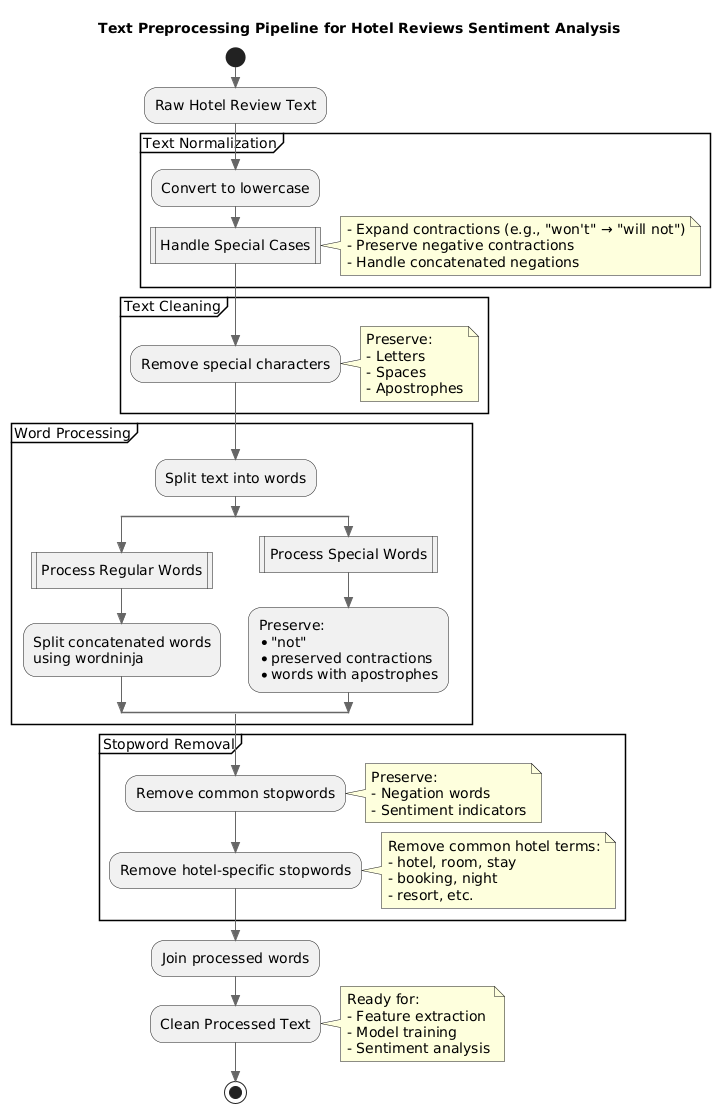

In [4]:
with open('diagrams/preprocessing.txt', 'r') as file:
    base64_string = file.read()
markdown_string = f'![Text_Pipeline](data:image/png;base64,{base64_string})'
markdown_string = f'![Text_Pipeline](data:image/png;base64,{base64_string})'
display(Markdown(markdown_string))

Debido a la calidad pobre de muchas reviews en el dataset (como la que se muestra en el ejemplo debajo de esta celda), y al desbalanceo que se ve en el histograma de esta sección, es que se deciden las siguientes modificaciones:

- Se dropean filas de clases mayoritarias 5 y 4 para atajar el problema de desbalance y, al ser clases positivas en un extremo, son las que poseen menos lenguaje neutro. Por lo tanto, entendemos que tener menos filas no afectara considerablemente en la detección de los patrones necesarios para clasificarlas
- Se agregan reviews en las clases minoritarias 1, 2 y 3 respectivamente utilizando un LLM SoTA. Puntualmente, utilizamos **meta-llama/Llama-3.2-3B**. Los detalles de como se generaron estas reviews se observa en el apéndice de esta notebook

### TfidfVectorizer

El `TfidfVectorizer` es una herramienta de preprocesamiento de texto de la librería `scikit-learn` que convierte un conjunto de documentos de texto en una matriz de características basada en el cálculo de la frecuencia inversa de término-documento (TF-IDF).

#### Principales componentes de TF-IDF
1. **TF (Term Frequency)**: Representa la frecuencia de un término en un documento, es decir, cuántas veces aparece una palabra en relación con el total de palabras en el documento.
2. **IDF (Inverse Document Frequency)**: Evalúa la importancia de un término en el corpus completo. Reduce el peso de palabras comunes que aparecen en muchos documentos, como palabras vacías (stopwords).

La fórmula para calcular el peso \( \text{TF-IDF}(t, d) \) de un término \( t \) en un documento \( d \) es:
\[
\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \log\left(\frac{N}{1 + \text{DF}(t)}\right)
\]
Donde:
- \( N \): Número total de documentos.
- \( \text{DF}(t) \): Número de documentos que contienen el término \( t \).

#### Funcionalidades principales
- **Normalización**: Los valores pueden ser normalizados para evitar que los documentos largos dominen las similitudes.
- **Stopwords**: Soporta la eliminación de palabras irrelevantes.
- **N-grams**: Puede considerar secuencias de palabras (bigramas, trigramas) como características.

#### Ventajas
- Capta la importancia relativa de las palabras en el contexto del documento y el corpus.
- Reduce el impacto de palabras comunes.

El `TfidfVectorizer` es fundamental para transformar datos textuales en características numéricas que los modelos de aprendizaje automático puedan procesar de manera efectiva.


# Busqueda de Hiper Parámetros

Como punto de partida se intentó realizar una representación de las variables con una reducción dimensional t-SNE, donde pudimos inferir que ciertas palabras era claves para poder discriminar entre sentimientos, pero que a su vez habia muschas otras que se solapaban.

En la selección de los modelos para evaluar se utilizaron los siguientes criterios:
- Regresión Lineal como línea base por su simplicidad y capacidad en los problemas de clasificación multinomial.
- SVC lineal por su simplicidad y velocidad, utilizando la estrategia OVO para mejorar las fronteras de clasificación
- SVC RBF, para poder clasificar en escenarios más complejos donde las fronteras lineales no puede
- Catboots y LightGBM para utilizar los métodos de boosting en busqueda de minimizar el error
- Ensemble con VotingClassifier para combinar las distintas características de los modelos.

Se implementaron dos técnicas principales para la optimización de hiperparámetros:

- **Optuna**: Se utilizó para encontrar los mejores hiperparámetros en los siguientes modelos:
  - SVC con kernel lineal.
  - SVC con kernel RBF.
  - CatBoost.
  - LightGBM.
- **GridSearchCV**: Aplicado para la regresión logística debido a su simplicidad y naturaleza interpretativa.

Los parámetros evaluados incluyeron:

- **SVC**: Regularización (C), kernel (lineal o RBF) y gamma (para RBF).
- **CatBoost y LightGBM**: Número de iteraciones, tasa de aprendizaje, y profundidad de árboles.
- **Regresión logística**: Parámetro de regularización (C).


# Inferencia de los modelos y comparaciones

Los modelos fueron instanciados con los mejores parámetros encontrados y evaluados utilizando métricas como:
- Precisión.
- F1-score.
- Matriz de confusión.

Resultados destacados:

1. **SVC (RBF)**: Excelente capacidad para capturar relaciones no lineales en los datos.
2. **CatBoost**: Mejor rendimiento en términos de rapidez y manejo de características categóricas.
3. **LightGBM**: Competitivo en precisión y velocidad de predicción.
4. **Regresión logística**: Resultado base interpretativo, con menor precisión comparado con los modelos complejos.

# Conclusiones